# Weather in Australia

The purpose of this notebook is to practice exploratory data analysis, preprocessing of features and modelling skills. The data was downloaded from [Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package).

In [46]:
# automatic reloading of modules before executing user code
%load_ext autoreload
%autoreload 2

# matplotlib
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import locale
import calendar

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
locale.setlocale(locale.LC_ALL, 'en_US.utf8')

'en_US.utf8'

In [10]:
# preprocessing
from pipeline_utils import * # custom transformers
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, StratifiedKFold

# modelling
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

# hyperparameters tuning
from scipy.stats import randint, uniform
from functools import partial
from hyperopt import hp, fmin, tpe, space_eval, Trials

# black-box explanation
from eli5 import explain_prediction, explain_weights, show_prediction, show_weights

In [77]:
# load data
ramka = pd.read_csv('/home/kuba/Downloads/weather_aus/weatherAUS.csv')

# firstly we need to drop Risk_MM column which is the amount of next day rain in mm.
# It is used to create response variable RainTomorrow
ramka.drop(columns="RISK_MM", inplace=True)

# Exploratory Data Analysis
Getting know the data is the first step in every machine learning pipeline. Understanding its structure, size and quality is very important as it shapes all the further actions. We do so by glancing at some rows of the data, checking basic statistics for each of the feature, analyze completness of data (are there many NaN's?) etc.

In [21]:
ramka.dtypes # what columns do we have?

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [16]:
ramka.head() # how our data looks like?

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [22]:
ramka.describe(include=np.number) # basic statistics for numerical columns

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


In [25]:
ramka.describe(include=np.object) # basic statistics for categorical columns

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,142193,142193,132863,132180,138415,140787,142193
unique,3436,49,16,16,16,2,2
top,2016-08-01,Canberra,W,N,SE,No,No
freq,49,3418,9780,11393,10663,109332,110316


Some columns have more than 40% of missing data. We will impute those missing values in the next part of the analysis.

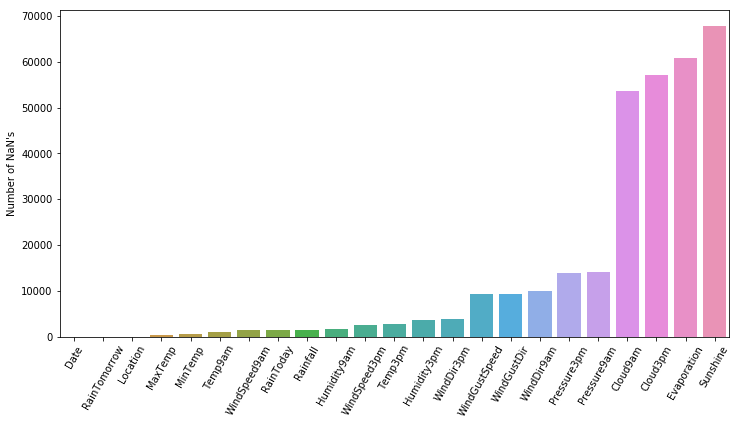

In [33]:
# which columns have the most NaN's?
nans_count = ramka.isna().sum().sort_values()

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(nans_count.index, nans_count, ax=ax)
plt.xticks(rotation=60)
plt.ylabel("Number of NaN's")
plt.show()

Let's check whether the dependent variable is imbalanced (some classes are over/underrepresented). If it occurs we should not use accuracy as a metric of model's quality in the modeling phase, especially if we are interested in predicting the infrequent class.

In [86]:
# is there a class imbalance?
sns.countplot(ramka['RainTomorrow'])
ramka['RainTomorrow'].value_counts() / ramka.shape[0]

NameError: name 'ramka' is not defined

We aim to find features that are correlated with dependent variable (binary _RainTomorrow_) and not correlated with each other as it may hinder model's performance. For example multicollinearity in linear models leads to uncertainty of estimates.

Below there is a plot of rain probability as a function of wind direction.

Text(0, 0.5, 'Fraction of observations')

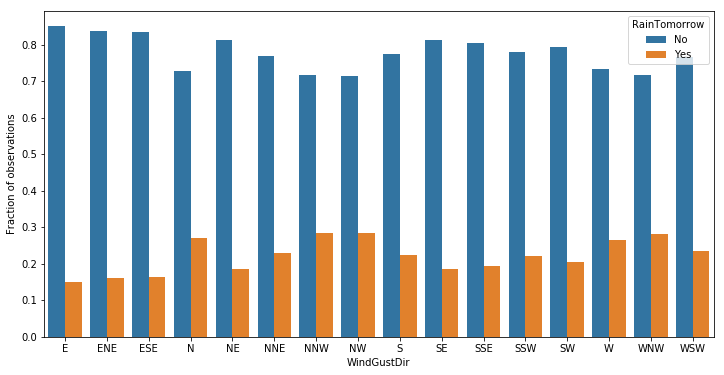

In [47]:
# is there a correlation between wind direction and rain?
cat_data = ramka.groupby("WindGustDir")['RainTomorrow'].value_counts().unstack(1)
cat_data = cat_data.apply(lambda x: x / cat_data.sum(1)).reset_index()
cat_data = pd.melt(cat_data, id_vars=['WindGustDir'], value_vars=['No', 'Yes'])

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x='WindGustDir', y='value', hue='RainTomorrow', data=cat_data, ax=ax)
plt.ylabel("Fraction of observations")
plt.show()

In [61]:
# extreme temperatures
temp_cols = ['Date', 'Location',]
min_temp = ramka.loc[ramka['MinTemp'] == ramka['MinTemp'].min()][temp_cols + ['MinTemp']]
max_temp = ramka.loc[ramka['MaxTemp'] == ramka['MaxTemp'].max()][temp_cols + ['MaxTemp']]
print("Minimum temperature:", min_temp, sep="\n")
print("Maximum temperature:", max_temp, sep="\n")

Minimum temperature:
             Date     Location  MinTemp
50958  2009-06-11  MountGinini     -8.5
Maximum temperature:
              Date Location  MaxTemp
103729  2011-01-25  Woomera     48.1


Seasonality of temperature in Australia. As it is situated on a southern hemisphere, the summer lasts from December to March.

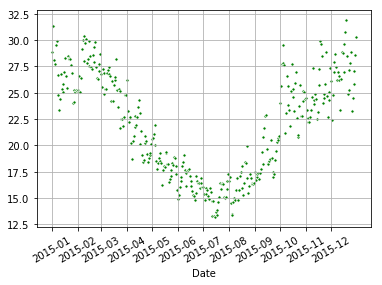

In [63]:
# mean temperature heatmap month vs. year
ramka['Year'] = ramka['Date'].str[:4]
ramka['Month'] = ramka['Date'].str[5:7]
ramka['Day'] = ramka['Date'].str[8:10]

wyn = ramka[ramka.Year=='2015'].groupby('Date')['Temp3pm'].agg(np.mean)
kw_scat = {'color':'g', 's':10}
g = sns.scatterplot(x=wyn.index, y=wyn.values, **kw_scat)
loc = [x for x in wyn.index.values if x[-2:]=='01']
plt.xticks(loc, labels=[str(x)[:7] for x in loc], rotation=30)
g.grid(True)

Despite the news about global warming acceleration there isn't any visible pattern in temperature changes within last 10 years.

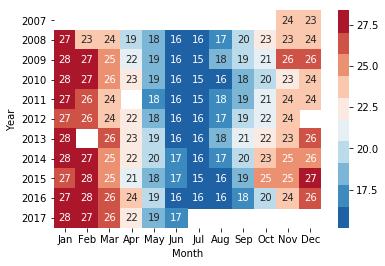

In [66]:
heat_data_gr = ramka.groupby(['Year', 'Month'])['Temp3pm']
heat_data = heat_data_gr.agg(np.mean).unstack(1)


h = sns.heatmap(data=heat_data,
                cmap=sns.color_palette("RdBu_r", 10),
                fmt='.0f',
                annot=True)
h.set_xticklabels(calendar.month_abbr[1:])
plt.show()

In [ ]:
# are there large amplitudes of temperature within the same day?
kw = {'color':'orange'}
sns.jointplot(x='MinTemp', y='MaxTemp', kind="kde", data=ramka, **kw)

In [73]:
# Where the sun shines the most?
sun_hard = ramka.groupby("Location")['Sunshine'].agg(np.mean) # many locations don't collect data
sun_hard[sun_hard>0].reset_index().sort_values("Sunshine", ascending=False).head()

,Location,Sunshine
2,AliceSprings,9.581944
29,Woomera,9.063005
14,Moree,8.896590
18,PearceRAAF,8.894160
20,PerthAirport,8.795306


Is there a correlation between humidity level and rain? One could spot that higher humidity is a good predictor of rain occuring.

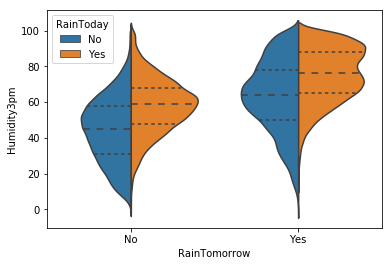

In [74]:
sns.violinplot(x='RainTomorrow', y='Humidity3pm', hue='RainToday',
               inner='quart', split=True,
               data=ramka)

# Feature engineering and preprocessing
Feature preprocessing is a vital part of any machine learning pipeline. Scikit-learn package enables creation of custom transformers which have multiple advantages:
* they are often combined with regressors, classifiers to build a composite estimator
* they all have very similar API and implement `fit()` and `transform()` methods
* they prevent data leakage as they can be fitted on training set and transformed on any other set
* they can be combined in a `Pipeline` which is a convinient way to perform all transformations at with a single call and make it possible to grid/random search over parameters of all estimators in the pipeline at once

Below there is an example of custom `Imputer` class which enables replacing missing values (all other transformers  are imported from `pipeline_utils` module at the beginning of this notebook).

In [ ]:
class Imputer(TransformerMixin):
    def __init__(self, strategy="median"):
        self.strat = strategy
        self.col_values = {}
        self.fun_dict = {"median": np.nanmedian,"mean": np.nanmean,
                         "most_frequent": lambda x: x.value_counts().argsort().index[0],
                         }

    def fit(self, X, y=None, **fit_args):
        for col in X.columns:
            self.col_values[col] = self.fun_dict[self.strat](X[col])
        return self

    def transform(self, X, y=None):
        return X.fillna(value=self.col_values)

Let's split a dataset into train and test set. Test set is one-third of the original dataframe. Furthermore, to ensure correct representation of classes, the splitting process is stratified using dependent variable.

In [78]:
X = ramka
y = ramka.pop("RainTomorrow")
y = LabelEncoder().fit_transform(y)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.33, random_state=2019)
del ramka

Creating separate preprocessing pipelines for numerical and categorical features.

In [80]:
# NUMERICAL PIPELINE
num_pipeline = Pipeline([
    ("PickNum", FunctionTransformer(lambda df: df.select_dtypes(include=[np.number]), validate=False)),
    ("FillNaN", Imputer(strategy="mean")),
    ("Scaler", Standardize()),
])

# CATEGORICAL PIPELINE
cat_pipeline = Pipeline([
    ("PickCar", FunctionTransformer(lambda df: df.select_dtypes(exclude=[np.number]), validate=False)),
    ("FillNaN", Imputer(strategy="most_frequent")),
    # ("CalcProbCat", ProbRain(features=["WindGustDir"])),
    ("Counter", CounterCat(cols=["Location", "WindGustDir"])),
    ("DateParts", GetDateParts()),
    ("OHT", OneHotEncode(exclude=["Date"])),
])

In [82]:
# concatenation of numeric and categorical features
feat_union = FeatureUnion([
    ("numeric", num_pipeline),
    ("categoric", cat_pipeline)
]) # unfortunately doesn't preserve pandas df and the wrapper doesn't work in the latest sklearn version...

# so we concat manually:
num_train = num_pipeline.fit_transform(X_train_raw, y_train)
cat_train = cat_pipeline.fit_transform(X_train_raw, y_train)

X_train = pd.concat([num_train, cat_train], axis=1)
X_test = pd.concat([num_pipeline.transform(X_test_raw), cat_pipeline.transform(X_test_raw)], axis=1)

# Modelling
Now that the dataset is ready to be fed into classifiers we should set a benchmark which we would like to improve upon. A dummy classifier which simply predicts the most frequent class is the lower bound of our ambitions.
We will try 4 different classifiers (Support Vector Classifier, Logistic Regression, Random Forest Classifier and XGBoost) to see which performs the best. The best model will be further tuned for better hyperparameters to improve its performance even more.

In [ ]:
# set a benchmark - dummy classifier
dummy = DummyClassifier(strategy="most_frequent", random_state=2019)
# select some classifiers with default settings to see which to tune further
svc = SVC(random_state=2019)
log = LogisticRegression(random_state=2019)
rf = RandomForestClassifier(random_state=2019)
xgb = XGBClassifier(random_state=2019)

clf_all = [dummy, log, svc, rf, xgb]

results = {}
for est in clf_all:
    est_name = est.__class__.__name__
    if est_name=="DummyClassifier":
        metrics = ['accuracy', 'roc_auc']
    else:
        metrics = ['accuracy', 'f1_macro', 'roc_auc']

    # check performance
    score = cross_validate(est, X_train, y_train, cv=3, scoring=metrics, n_jobs=3,
                           return_train_score=False)
    print(est_name, "average:")
    for key in score.keys():
        print(key, ":", np.round(np.mean(score[key]), 3))
    print("----------")
    results[est_name] = np.mean(score["test_roc_auc"])

In [ ]:
# which algorithm to proceed further with?
print("And the winner is:", max(results, key=results.get))

The winner is XGBoost

In [ ]:
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
print(accuracy_score(y_test, preds))
print(roc_auc_score(y_test, preds))
print(log_loss(y_test, preds))

Hyperparameter tuning - create a grid of params

In [85]:
param_grid = {"n_estimators": randint(100, 2500),
              "learning_rate": np.logspace(-2, 1, 4).tolist(),
              "num_leaves": [2 ** x for x in range(4, 9)],
              "max_depth": [2, 4, 6, 8, 10, 12],
              # randomly pick 60-100% observations for each tree (goal: make training robust to noise):
              "subsample": uniform(0.6, 0.4),
              # randomly pick 60-100% columns available for each tree to split on (prevents overfitting):
              "colsample_bytree": uniform(0.6, 0.4),
              # recommended by documentation in case of class imbalance:
              "scale_pos_weight": [y_train.sum() / X_train.shape[0]]
              }

In [ ]:
random_search = RandomizedSearchCV(xgb_new, n_iter=30, scoring="roc_auc", cv=skf, param_distributions=param_grid,
                                  refit=True, n_jobs=2, random_state=2019, return_train_score=False, verbose=2)
hp_results = random_search.fit(X_train, y_train)

In [ ]:
hp_results.cv_results_
hp_results.refit_time_
hp_results.best_estimator_

In [ ]:
print("BEST PARAMETERS: " + str(hp_results .best_params_))
print("BEST CV SCORE: " + str(hp_results.best_score_))

In [ ]:
ax = plot_importance(xgb, importance_type="cover", max_num_features=20)
fig = ax.figure
plt.show()

# Model interpretation

In [ ]:
# show eli5 explanation in the future